In [33]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt

Base class

In [4]:
class baseModel:
    def forward(self, x):
        pass

    def backward(self, output, learning_rate):
        pass

### Convolution: There will be four (hyper)parameters:
1. Number of output channels
2. Filter dimension
3. Stride
4. Padding

In [5]:
class ConvolutionLayer(baseModel):
    def __init__(self, output_channel, kernel_size, stride, padding):
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = None
        self.bias = None

    def forward(self, x):
        self.x = x # batch_size, channel, height, width
        batch_size, channel, height, width = x.shape
        output_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        output_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1
        self.output = np.zeros((batch_size, self.output_channel,  output_height, output_width))
        if self.weights is None:
            # self.weights = np.random.randn(self.output_channel, channel, self.kernel_size, self.kernel_size)
            # init weight with Xavier method
            self.weights = np.random.randn(self.output_channel, channel, self.kernel_size, self.kernel_size) * np.sqrt(2 / (channel * self.kernel_size * self.kernel_size))
            self.bias = np.random.randn(self.output_channel)
        
        new_arr = np.lib.stride_tricks.as_strided(x, 
            shape=(batch_size, channel, output_height, output_width, self.kernel_size, self.kernel_size), 
            strides=(x.strides[0], x.strides[1], x.strides[2], x.strides[3], x.strides[2], x.strides[3]))

    
        self.output = np.einsum('bihwkl,oikl->bohw', new_arr, self.weights) + self.bias[None, :, None, None]
        return self.output

        
        
        # for i in range(batch_size):
        #     for j in range(self.output_channel):
        #         for k in range(self.output.shape[2]):
        #             for l in range(self.output.shape[3]):
        #                 self.output[i, j, k, l] = np.sum(self.weights[j] * x[i, :, k * self.stride:k * self.stride + self.kernel_size, l * self.stride:l * self.stride + self.kernel_size]) + self.bias[j]
        # return self.output

    # backward prop vectorized
    def backward(self, output, learning_rate):
        batch_size, channel, height, width = self.x.shape
        new_arr = np.lib.stride_tricks.as_strided(self.x, 
            shape=(batch_size, channel, output.shape[2], output.shape[3], self.kernel_size, self.kernel_size), 
            strides=(self.x.strides[0], self.x.strides[1], self.x.strides[2], self.x.strides[3], self.x.strides[2], self.x.strides[3]))

        self.weights -= learning_rate * np.einsum('bohw, bihwkl -> oikl', output, new_arr)
        self.bias -= learning_rate * np.sum(output, axis=(0, 2, 3))
        return np.einsum('bohw, oikl -> bihwkl', output, self.weights)
        

In [6]:
count = 1*1*5*5
input_arr = np.ones((1, 1, 5, 5))
print(f'input: {input_arr}\n')
conv_layer = ConvolutionLayer(2, 3, 1, 0)
print(conv_layer)
output = conv_layer.forward(input_arr)
print(output.shape)
print(f'output--------\n{output}\n')

input: [[[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]]]

(1, 2, 3, 3)
output--------
[[[[0.50613676 0.50613676 0.50613676]
   [0.50613676 0.50613676 0.50613676]
   [0.50613676 0.50613676 0.50613676]]

  [[1.45009799 1.45009799 1.45009799]
   [1.45009799 1.45009799 1.45009799]
   [1.45009799 1.45009799 1.45009799]]]]



### ReLU: 

In [7]:
class ReLULayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, output, learning_rate):
        self.output = output
        self.learning_rate = learning_rate
        self.delta = np.zeros(self.x.shape)
        return self.output * (self.x > 0)
        

In [8]:

output = ReLULayer().forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 2, 3, 3)
output--------
[[[[0.50613676 0.50613676 0.50613676]
   [0.50613676 0.50613676 0.50613676]
   [0.50613676 0.50613676 0.50613676]]

  [[1.45009799 1.45009799 1.45009799]
   [1.45009799 1.45009799 1.45009799]
   [1.45009799 1.45009799 1.45009799]]]]



### MaxPooling: There will be two parameters:
1. Filter dimension
2. Stride

In [9]:
class MaxPoolingLayer(baseModel):
    def __init__(self, kernel_size, stride):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        self.x = x
        batch_size, channel, height, width = x.shape
        output_height = (height - self.kernel_size) // self.stride + 1
        output_width = (width - self.kernel_size) // self.stride + 1
        self.output = np.zeros((batch_size, channel, output_height, output_width))
        
        # maxpooling without loop
        new_arr = np.lib.stride_tricks.as_strided(x, 
            shape=(batch_size, channel, output_height, output_width, self.kernel_size, self.kernel_size), 
            strides=(x.strides[0], x.strides[1], x.strides[2] * self.stride, x.strides[3] * self.stride, x.strides[2], x.strides[3]))
        self.output = np.max(new_arr, axis=(4, 5))
        return self.output

    def backward(self, output, learning_rate):
        self.output = output
        self.learning_rate = learning_rate
        self.delta = np.zeros(self.x.shape)
        for i in range(self.x.shape[0]):
            for j in range(self.x.shape[1]):
                for k in range(self.x.shape[2]):
                    for l in range(self.x.shape[3]):
                        if self.x[i, j, k, l] == np.max(self.x[i, j, k:k + self.kernel_size, l:l + self.kernel_size]):
                            self.delta[i, j, k, l] = self.output[i, j, k // self.stride, l // self.stride]
        return self.delta

In [10]:
output = MaxPoolingLayer(2, 1).forward(output)

print(output.shape)
print(f'output--------\n{output}\n')

(1, 2, 2, 2)
output--------
[[[[0.50613676 0.50613676]
   [0.50613676 0.50613676]]

  [[1.45009799 1.45009799]
   [1.45009799 1.45009799]]]]



### Flattening: 

In [11]:
class FlatteningLayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        batch_size, channel, height, width = x.shape
        self.output = x.reshape((batch_size, channel * height * width))
        return self.output

    def backward(self, output, learning_rate):
        self.output = output
        self.learning_rate = learning_rate
        self.delta = self.output.reshape(self.x.shape)
        return self.delta

In [12]:
output = FlatteningLayer().forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 8)
output--------
[[0.50613676 0.50613676 0.50613676 0.50613676 1.45009799 1.45009799
  1.45009799 1.45009799]]



### Fully-connected layer: a dense layer. There will be one paramete:
1. Output dimension

In [13]:
class FullyConnectedLayer(baseModel):
    def __init__(self, output_channel):
        self.output_channel = output_channel
        self.weights = None
        self.bias = None

    def forward(self, x):
        self.x = x
        if self.weights is None:
            self.weights = np.random.randn(self.x.shape[1], self.output_channel)
            self.bias = np.random.randn(self.output_channel)
        self.output = np.dot(self.x, self.weights) + self.bias
        return self.output

    def backward(self, output, learning_rate):
        self.output = output
        self.learning_rate = learning_rate
        self.delta = np.dot(self.output, self.weights.T)
        self.weights -= self.learning_rate * np.dot(self.x.T, self.output)
        self.bias -= self.learning_rate * np.sum(self.output, axis=0)
        return self.delta

In [14]:
output = FullyConnectedLayer(10).forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 10)
output--------
[[  7.29463499  -3.57604562   1.66583254  -0.16060834   1.78140787
    0.72982333  -5.85031161  -0.65892774  -1.23689914 -10.40373762]]



### Softmax: it will convert final layer projections to normalized probabilities

In [15]:
class SoftmaxLayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        self.output = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        return self.output

    def backward(self, output, learning_rate):
        self.output = output
        self.learning_rate = learning_rate
        self.delta = self.output
        return self.delta

In [16]:
output = SoftmaxLayer().forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 10)
output--------
[[9.89919667e-01 1.88158286e-05 3.55665803e-03 5.72570431e-04
  3.99241649e-03 1.39488523e-03 1.93562928e-06 3.47865654e-04
  1.95164921e-04 2.03842338e-08]]



### Create Model

In [43]:
def createModel():
    model = []
    
    model.append(ConvolutionLayer(2, 3, 1, 1))
    model.append(ReLULayer())
    model.append(MaxPoolingLayer(2, 2))
    model.append(ConvolutionLayer(2, 3, 1, 1))
    model.append(ReLULayer())
    model.append(MaxPoolingLayer(2, 2))
    model.append(FlatteningLayer())
    model.append(FullyConnectedLayer(10))
    model.append(SoftmaxLayer())
    print('model created: ', model)
    return model

In [38]:
# get images
def getImages(path):
    images = []
    for file in os.listdir(path):
        img = cv2.imread(os.path.join(path, file))
        img = cv2.resize(img, (128, 128))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = (255-img.transpose(2, 0, 1))/255
        images.append(img)
    return np.array(images)

In [30]:
# get labels
def getLabels(path):
    labels = []
    # using panda
    df = pd.read_csv(path)
    labels = df['digit']
    return np.array(labels)

In [40]:
# train
def train(model, X_train, X_test, Y_train, Y_test, learning_rate, epochs):
    for epoch in range(epochs):
        print(f'epoch: {epoch}')
        batch_size = 32
        num_batches = X_train.shape[0] // batch_size
        loss = 0
        for i in range(num_batches):
            # forward
            x_output = X_train[i*batch_size: (i+1)*batch_size]
            y_output = Y_train[i*batch_size: (i+1)*batch_size]

            for layer in model:
                x_output = layer.forward(x_output)
            
            #loss
            loss += log_loss(y_output, x_output)

            # backward
            for layer in reversed(model):
                x_output = layer.backward(x_output, learning_rate)
        
        # test
        val_loss = 0
        for layer in model:
            X_test = layer.forward(X_test)

        val_loss = log_loss(X_test, Y_test)

        print(f'loss: {loss/num_batches}, val_loss: {val_loss}')
        



(359, 3, 128, 128)
(359, 10)


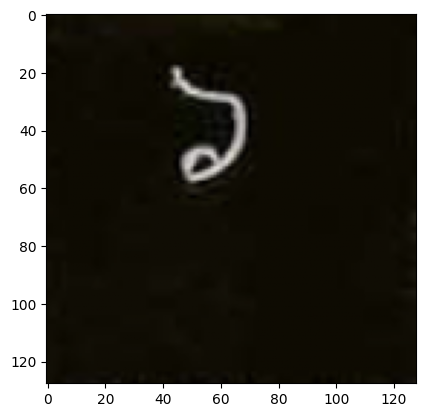

In [39]:
images = getImages('data/training-b')
labels = getLabels('data/training-b.csv')
# one hot encode
labels = np.eye(10)[labels]
print(images.shape)
print(labels.shape)
# view an image
plt.imshow(images[0].transpose(1, 2, 0))


In [45]:
# train model
model = createModel()

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
train(model, X_train, X_test, Y_train, Y_test, 0.001, 10)
# model

model created:  [<__main__.ConvolutionLayer object at 0x7fad0c5c4d90>, <__main__.ReLULayer object at 0x7fad0c5c4b20>, <__main__.MaxPoolingLayer object at 0x7fad0c5c49a0>, <__main__.ConvolutionLayer object at 0x7fad0c5c4dc0>, <__main__.ReLULayer object at 0x7fad0c5c4b50>, <__main__.MaxPoolingLayer object at 0x7fad0c5c4ee0>, <__main__.FlatteningLayer object at 0x7fad0c5c4760>, <__main__.FullyConnectedLayer object at 0x7fad0c5c4bb0>, <__main__.SoftmaxLayer object at 0x7fad0c5c4e80>]
epoch: 0


ValueError: operands could not be broadcast together with shapes (2,3,3) (64,) 